In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# === Step 1: 加载真实标签 ===
test_df = pd.read_csv("/root/lanyun-tmp/prediction/data/test_f.csv")
y_test = test_df["event"].values

# === Step 2: 加载各模型的预测概率 ===
cox_df = pd.read_csv("/root/lanyun-tmp/prediction/accuracy_data/prob/coxf_test_user_risk_scores.csv")
lda_df = pd.read_csv("/root/lanyun-tmp/prediction/accuracy_data/prob/lda_prob.csv")
logi_df = pd.read_csv("/root/lanyun-tmp/prediction/accuracy_data/prob/logistic_prob.csv")
rf_df = pd.read_csv("/root/lanyun-tmp/prediction/accuracy_data/prob/rf_prediction_with_prob.csv")
xgb_df = pd.read_csv("/root/lanyun-tmp/prediction/accuracy_data/prob/xgb_prediction_with_prob.csv")
xgb_cox_df = pd.read_csv("/root/lanyun-tmp/prediction/accuracy_data/prob/xgb_with_cox_prediction.csv")


In [24]:
def load_and_merge_prob(path, prob_col, user_col="user_id"):
    df = pd.read_csv(path)
    merged = pd.merge(test_df[["user_id"]], df[[user_col, prob_col]], on="user_id", how="left")
    return merged[prob_col].fillna(0).values  # 修复 NaN 问题


In [26]:
# 用 test_df["user_id"] 对齐所有模型输出
model_probs = {
    "Cox": load_and_merge_prob("/root/lanyun-tmp/prediction/accuracy_data/prob/coxf_test_user_risk_scores.csv", "risk_score"),
    "Cox + XGBoost": load_and_merge_prob("/root/lanyun-tmp/prediction/accuracy_data/prob/coxf_test_user_risk_scores.csv", "risk_score"),
    "LDA": load_and_merge_prob("/root/lanyun-tmp/prediction/accuracy_data/prob/lda_prob.csv", "prob"),
    "Logistic Regression": load_and_merge_prob("/root/lanyun-tmp/prediction/accuracy_data/prob/logistic_prob.csv", "prob"),
    "Random Forest": load_and_merge_prob("/root/lanyun-tmp/prediction/accuracy_data/prob/rf_prediction_with_prob.csv", "predicted_prob"),
    "XGBoost": load_and_merge_prob("/root/lanyun-tmp/prediction/accuracy_data/prob/xgb_prediction_with_prob.csv", "predicted_prob"),
    "XGBoost + Cox Feature": load_and_merge_prob("/root/lanyun-tmp/prediction/accuracy_data/prob/xgb_with_cox_prediction.csv", "predicted_prob"),
}


In [27]:
from sklearn.metrics import roc_auc_score

print("=== 📊 Test AUC Comparison ===")
auc_scores = {}
for name, prob in model_probs.items():
    auc = roc_auc_score(y_test, prob)
    auc_scores[name] = auc
    print(f"{name}: AUC = {auc:.4f}")


=== 📊 Test AUC Comparison ===
Cox: AUC = 0.8453
Cox + XGBoost: AUC = 0.8453
LDA: AUC = 0.5069
Logistic Regression: AUC = 0.5232
Random Forest: AUC = 0.5210
XGBoost: AUC = 0.5033
XGBoost + Cox Feature: AUC = 0.5037


In [29]:
def precision_recall_at_k(prob, y_true, topk_percent=1.0):
    n = int(len(prob) * topk_percent / 100)
    top_idx = np.argsort(prob)[::-1][:n]
    y_top = np.array(y_true)[top_idx]
    precision = np.mean(y_top)
    recall = np.sum(y_top) / np.sum(y_true)
    return precision, recall

print("\n===Precision@K & Recall@K ===")
for name, prob in model_probs.items():
    print(f"\n{name}:")
    for k in [1, 3, 5, 10]:
        p, r = precision_recall_at_k(prob, y_test, topk_percent=k)
        print(f"Top {k}% — Precision: {p:.4f}, Recall: {r:.4f}")



===Precision@K & Recall@K ===

Cox:
Top 1% — Precision: 0.0500, Recall: 0.2278
Top 3% — Precision: 0.0252, Recall: 0.3444
Top 5% — Precision: 0.0183, Recall: 0.4159
Top 10% — Precision: 0.0120, Recall: 0.5445

Cox + XGBoost:
Top 1% — Precision: 0.0500, Recall: 0.2278
Top 3% — Precision: 0.0252, Recall: 0.3444
Top 5% — Precision: 0.0183, Recall: 0.4159
Top 10% — Precision: 0.0120, Recall: 0.5445

LDA:
Top 1% — Precision: 0.0073, Recall: 0.0332
Top 3% — Precision: 0.0048, Recall: 0.0650
Top 5% — Precision: 0.0044, Recall: 0.0991
Top 10% — Precision: 0.0032, Recall: 0.1480

Logistic Regression:
Top 1% — Precision: 0.0070, Recall: 0.0318
Top 3% — Precision: 0.0056, Recall: 0.0770
Top 5% — Precision: 0.0047, Recall: 0.1079
Top 10% — Precision: 0.0035, Recall: 0.1591

Random Forest:
Top 1% — Precision: 0.0064, Recall: 0.0290
Top 3% — Precision: 0.0045, Recall: 0.0618
Top 5% — Precision: 0.0041, Recall: 0.0941
Top 10% — Precision: 0.0033, Recall: 0.1521

XGBoost:
Top 1% — Precision: 0.0062, 

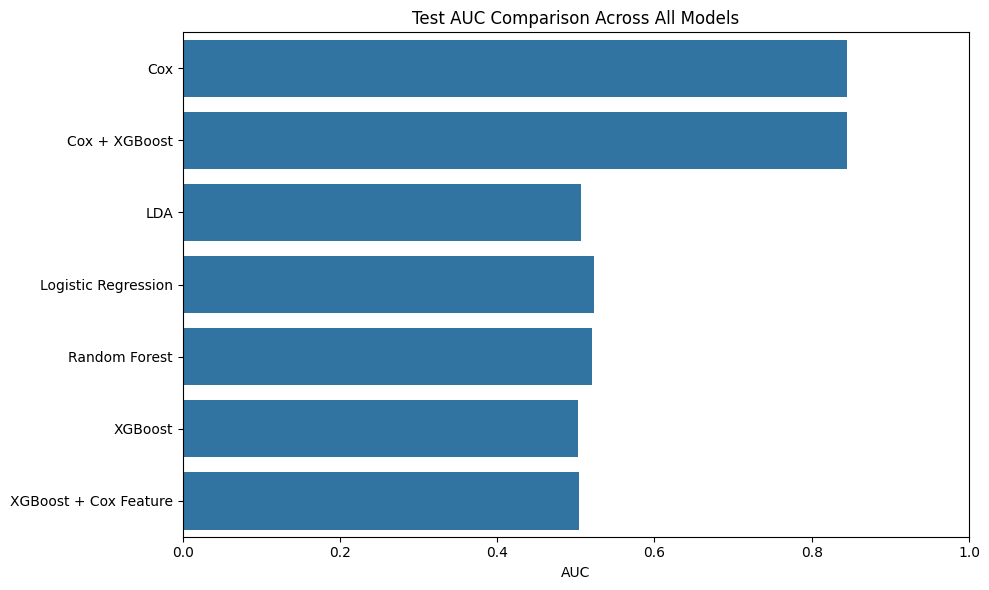

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=list(auc_scores.values()), y=list(auc_scores.keys()))
plt.xlabel("AUC")
plt.title("Test AUC Comparison Across All Models")
plt.xlim(0.0, 1.0)
plt.tight_layout()
plt.show()
